# SGP-Based IPP

In [ ]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
import tensorflow as tf

from sgptools.utils.metrics import *
from sgptools.utils.data import *
from sgptools.utils.misc import *
from sgptools.utils.tsp import run_tsp
from sgptools.utils.gpflow import get_model_params
from sgptools.models.continuous_sgp import *
from sgptools.models.core.transformations import *

import matplotlib.pyplot as plt

np.random.seed(1234)
tf.random.set_seed(1234)

# Get the data and initial SGP hyperparameters

╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═════════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value               │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═════════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.6576268242419765  │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [2.95895 2.25221]   │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼─────────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.02576014673391919 │


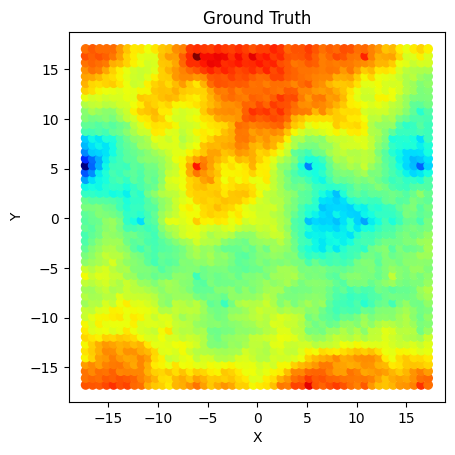

In [2]:
# Get the synthetic elevation data
X_train, y_train, X_test, y_test, candidates, X, y = get_dataset()

# Train the GP and get the model parameters
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[1.0, 1.0], 
                                             optimizer='scipy')
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='jet')
plt.title("Ground Truth")
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().set_aspect('equal')
plt.show()

# Single-Robot IPP with Point Sensing

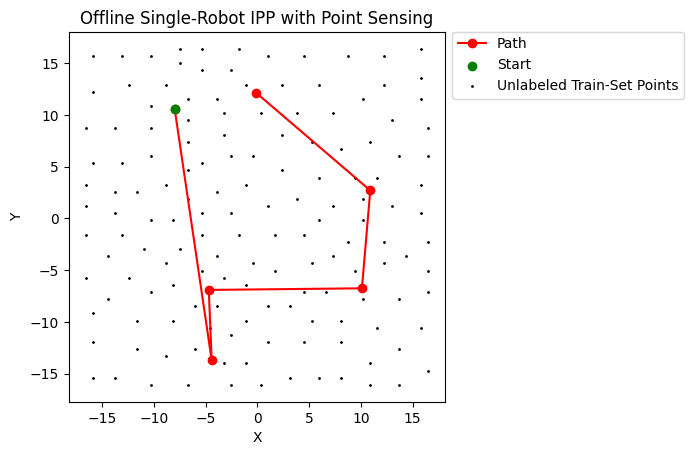

In [3]:
num_robots = 1
num_placements = 6

# Initialize inducing points and get initial path
Xu_init = get_inducing_pts(X_train, 
                           num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots)
Xu_init = Xu_init[0]

# Setup unconstrained IPP transform and optimize it
transform = IPPTransform(num_robots=num_robots, num_dim=2)
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=1000)

# Get solution inducing points
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()
sgp_paths = sgp_sol_sp.reshape(num_robots, num_placements, 2)

# Plot the solution
plot_paths(sgp_paths, candidates,
           title="Offline Single-Robot IPP with Point Sensing")

# Single-Robot IPP with Continuous Sensing

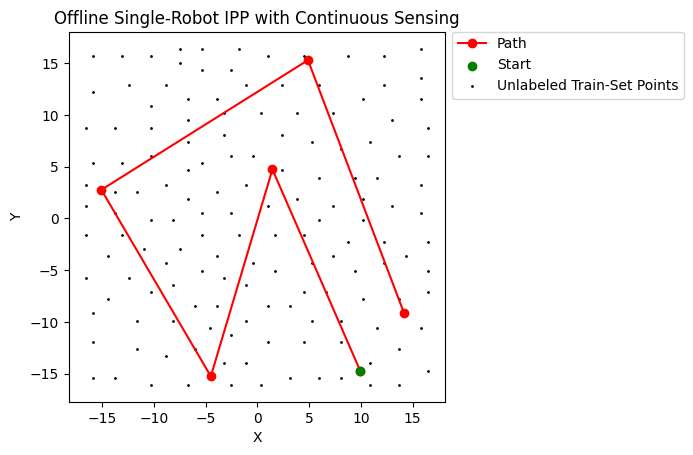

In [4]:
num_robots = 1
num_placements = 6

# Initialize inducing points and get initial path
Xu_init = get_inducing_pts(X_train, num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots)
Xu_init = Xu_init[0]

# Setup unconstrained IPP transform with sampling rate=5
# and optimize it
transform = IPPTransform(num_robots=num_robots,
                           num_dim=2,
                           sampling_rate=5)
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=1000)

# Get solution inducing points
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()
sgp_paths = sgp_sol_sp.reshape(num_robots, num_placements, 2)

# Plot the solution
plot_paths(sgp_paths, candidates, 
           title="Offline Single-Robot IPP with Continuous Sensing")

# Single-Robot IPP with Continuous Non-point FoV Sensor

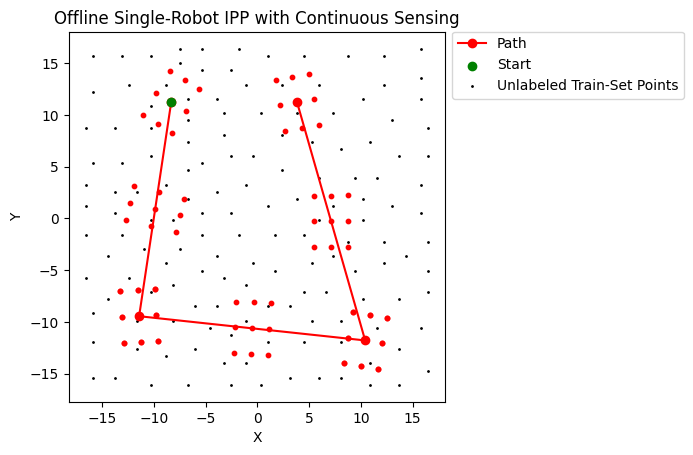

In [5]:
num_robots = 1
num_placements = 4

# Initialize inducing points and get initial path
Xu_init = get_inducing_pts(X_train, num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots)
Xu_init = Xu_init[0]

# Add random angles to inducing points to initialize the rotation angle of the FoVs
angles = np.random.uniform(-np.pi, np.pi, num_placements).reshape(-1, 1)
Xu_init = np.concatenate([Xu_init, angles], axis=1)

# Setup unconstrained IPP transform with square FoV transform 
# with length 5 and 3x3 point approximation, 
# and continuous sensing model (sampling rate of 3), and optimize it
square_transform = SquareTransform(length=5, num_side=3)
transform = IPPTransform(num_robots=num_robots,
                         num_dim=3,
                         sampling_rate=3,
                         sensor_model=square_transform)
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=1000)

# Get solution inducing points
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()[:, :2]
sgp_paths = sgp_sol_sp.reshape(num_robots, -1 , 2)

# Plot the solution path and the FoVs
plot_paths(sgp_paths, candidates, 
           title="Offline Single-Robot IPP with Continuous Sensing")
sgp_sol_sp = sgpr.inducing_variable.Z
sgp_sol_sp = sgpr.transform.expand(sgp_sol_sp,).numpy()
plt.scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], s=10, c='r')

# Multi-Robot IPP with Continuous Sensing and a Distance Budget

Distances: [30.         29.9984054  29.98115566]


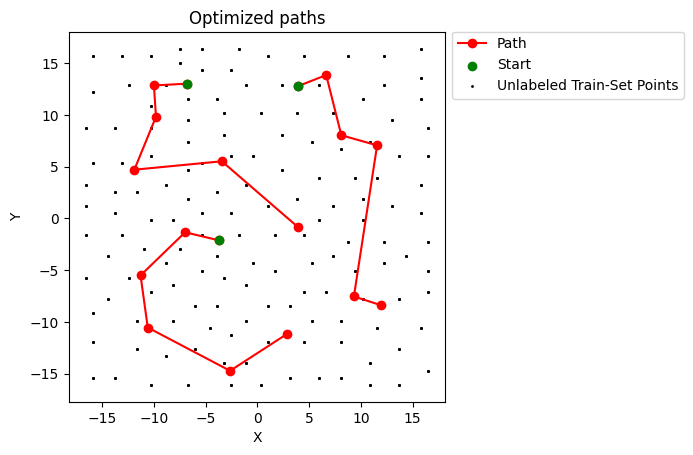

In [6]:
num_robots = 3
num_placements = 6

# Initialize inducing points and get initial path 
# resample to ensure same number of waypoints in each path
Xu_init = get_inducing_pts(X_train, num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots,
                     max_dist=100,
                     resample=num_placements)
Xu_init = Xu_init.reshape(-1, 2)

# Setup distance constrained 3 robot IPP transform
# with continuous sensing model (sampling rate of 5) and 
# a distance budget of 30.0 and optimize it
transform = IPPTransform(num_robots=num_robots,
                         num_dim=2,
                         sampling_rate=5,
                         distance_budget=30.,
                         constraint_weight=100.)
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=5000)

# Get solution inducing points
sol_sp = sgpr.inducing_variable.Z.numpy()
sol_paths = sol_sp.reshape(num_robots, 
                           num_placements, 2)

# Plot the solution path
plot_paths(sol_paths, candidates, title="Optimized paths")
print("Distances:", transform.distance(sol_sp).numpy())